In [39]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import seaborn as sns
import warnings
import wikipediaapi  # For accessing Wikipedia
from bs4 import BeautifulSoup  # For parsing HTML
import pywikibot
from datetime import datetime
import scipy.stats as stats 

import spacy
from spacy.matcher import PhraseMatcher

## Data Collection

In [ ]:
wiki_wiki = wikipediaapi.Wikipedia('en')

In [ ]:
import re
import numpy as np

def get_articles(category, level=0, max_level=2):
    #seen_categories = set()
    #seen_articles = set()
    excluded_keywords = ["violence", "list","eunuchs","stubs","deaths from","asexual men"]  # Keywords to exclude
    articles_list = []
    cat_members = category.categorymembers.values()

    # Create a list of pages and split it into chunks of 200
    pages = list(cat_members)
    page_chunks = np.array_split(pages, len(pages)//200 + 1)

    for chunk in page_chunks:
        for c in chunk:
            if c.namespace == wikipediaapi.Namespace.CATEGORY and level < max_level and c.title not in seen_categories:
                seen_categories.add(c.title)
                # Exclude categories with specific keywords
                if not any(keyword in c.title.lower() for keyword in excluded_keywords):
                    # Check if the category is 'Male genital disorders'
                    if c.title in ['Category:Male genital disorders','Category:Male infertility']:
                        articles_list.extend(get_articles(c, level=level+1, max_level=max_level+2))  # Increase max_level for this category
                    else:
                        articles_list.extend(get_articles(c, level=level+1, max_level=max_level))
            elif c.namespace == wikipediaapi.Namespace.MAIN and c.title not in seen_articles:
                seen_articles.add(c.title)
                # Exclude pages with specific keywords in title
                if not any(keyword in c.title.lower() for keyword in excluded_keywords):
                    articles_list.append(c)
    return articles_list


In [ ]:
cat = wiki_wiki.page("Category:Women's_health")
seen_categories = set()
seen_articles = set()
women_health_articles = get_articles(cat)

In [ ]:
cat = wiki_wiki.page("Category:Men's_health")
seen_categories = set()
seen_articles = set()
men_health_articles = get_articles(cat)

In [ ]:
# MAIN CODE

import requests
import json
import time
import pandas as pd
import pywikibot
import urllib.parse
from ratelimiter import RateLimiter
from datetime import datetime, timedelta
from pywikibot.exceptions import PageRelatedError
from concurrent.futures import ThreadPoolExecutor

# Define the retry limit and delay
retry_limit = 3
retry_delay = 5  # in seconds

# Define the number of threads to use for concurrent requests
num_threads = 5

HEADERS = {'User-Agent': 'MyResearchProject/2.0 (mm22ajk@leeds.ac.uk) MyResearchProjectDataCollection2'}
SITE = pywikibot.Site('en', 'wikipedia')

# Set the rate limit values
#rate_limit = 40  # Number of requests
#rate_period = 60  # Time period in seconds

# Configure the rate limiter
#rate_limiter = RateLimiter(max_calls=rate_limit, period=rate_period)

#@rate_limiter
def get_pageviews(title):
    try:
        title = urllib.parse.quote(title.replace(' ', '_'),safe=' ')
        url = f"https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/{title}/monthly/2022050100/2023053100"
        response = requests.get(url, headers=HEADERS)
        response.raise_for_status()  # raise exception if the request failed
        data = response.json()
        total_yearly_views = sum(item["views"] for item in data["items"])
    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch pageviews for {title}: {e}")
        total_yearly_views = np.nan
    except (json.JSONDecodeError, KeyError) as e:
        print(f"Error parsing JSON response for {title}: {e}")
        total_yearly_views = np.nan
    except Exception as e:
        print(f"An unexpected error occurred for {title}: {e}")
        total_yearly_views = np.nan

    return total_yearly_views

def get_link_counts(title):
    results = {}
    page = pywikibot.Page(SITE, title)
    results["external_links"] = len(list(page.extlinks()))
    results["internal_links"] = len(list(page.linkedPages()))
    return results

def get_edit_history(title):
    try:
        page = pywikibot.Page(SITE, title)

        # Get the number of revisions
        num_revisions = page.revision_count()

        # Get the main author (first contributor) and date of creation
        main_author = page.oldest_revision.user
        date_of_creation = page.oldest_revision.timestamp.date()

        # Get the number of recent edits in the last 30 days
        thirty_days_ago = datetime.now() - timedelta(days=30)
        recent_edits = [
            rev for rev in page.revisions(content=False) if rev.timestamp > thirty_days_ago
        ]
        num_recent_edits = len(recent_edits)

        # Get the date of the latest edit
        latest_revision = next(page.revisions(total=1, content=False))
        date_of_latest_edit = latest_revision.timestamp.date()

        # Return the collected information
        edithistory = {
            'num_revisions': num_revisions,
            'main_author': main_author,
            'date_of_creation': date_of_creation,
            'num_recent_edits': num_recent_edits,
            'date_of_latest_edit': date_of_latest_edit
        }

        return edithistory

    except PageRelatedError as e:
        print(f"Error: {e}")
        return None
    except requests.exceptions.ReadTimeout as e:
        print("Timeout occurred. Retrying after 5 seconds...")
        time.sleep(5)
        return get_edit_history(title)


# Configure the rate limiter
#rate_limiter_bot = RateLimit(rate=rate_limit, period=rate_period)

# Set the rate limiter for all API requests
#pywikibot.config.rate_limit = rate_limiter

# Set the rate limiter for the get_edithistory function
#get_edit_history = rate_limiter(get_edit_history)


def get_article_details(article):
    pageid = article.pageid
    title = article.title
    content = article.text
    page_view_year = get_pageviews(title)
    link_counts = get_link_counts(title)
    edit_history = get_edit_history(title)
    details = {
        'pageid': pageid,
        'title': title,
        'author' : edit_history['main_author'],
        'date_of_creation' : edit_history['date_of_creation'],
        'num_revs' : edit_history['num_revisions'],
        'num_recent_edits' : edit_history['num_recent_edits'],
        'date_of_latest_edit' : edit_history['date_of_latest_edit'],
        'page_views_yr': page_view_year,
        'internal_links': link_counts["internal_links"],
        'external_links': link_counts["external_links"],
        'word_count': len(content.split()),
        'content': content}
    return details

def collect_data(articles):
    data = []
    
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        for article in articles:
            retry_count = 0
            success = False
            
            while retry_count < retry_limit and not success:
                try:
                    article_details = get_article_details(article)
                    data.append(article_details)
                    success = True
                except requests.exceptions.RequestException as e:
                    print(f"Error in API request for {article.title}: {e}")
                    retry_count += 1
                    time.sleep(retry_delay)
                except Exception as e:
                    print(f"An unexpected error occurred for {article.title}: {e}")
                    success = True  # Skip the current article
                    
    return data

# Define the chunk size
chunk_size = 500

# specify womens or mens article here
# Split the articles into chunks
article_chunks = [women_health_articles[i:i + chunk_size] for i in range(0, len(women_health_articles), chunk_size)]

# Create an empty DataFrame to store the data
final_women_df = pd.DataFrame()

# Iterate over the chunks
for chunk in article_chunks:
    print('Starts processing a chunk')
    # Start the timer for each chunk
    start_time = time.time()

    # Process the articles in the chunk
    data = collect_data(chunk)

    # End the timer for each chunk
    end_time = time.time()

    # Calculate the total time for the chunk
    total_time = end_time - start_time

    # Convert total_time to minutes and seconds
    minutes = int(total_time // 60)
    seconds = int(total_time % 60)
    print('Total execution time for chunk: {} minutes {} seconds'.format(minutes, seconds))
    print('Waiting for 5 mins')
    print('_________________________________________________________________________')
    # Wait for 5 minutes before processing the next chunk
    time.sleep(300)  # 5 minutes = 5 * 60 seconds
    
    # Append the data for the chunk to the final DataFrame
    final_women_df = final_women_df.append(data, ignore_index=True)

In [ ]:
import requests
import pandas as pd

def get_quality(title):
    S = requests.Session()
    URL = "https://en.wikipedia.org/w/api.php"

    PARAMS = {
        "action": "query",
        "format": "json",
        "prop": "categories",
        "titles": f"Talk:{title}"
    }

    try:
        R = S.get(url=URL, params=PARAMS)
        R.raise_for_status()  # Raises stored HTTPError, if one occurred.
    except requests.exceptions.RequestException as e:
        print(f"Error with request for {title}: {e}")
        return "Request Error"

    try:
        DATA = R.json()
        pages = DATA["query"]["pages"]
    except KeyError as e:
        print(f"Error with response data for {title}: {e}")
        return "Data Error"

    quality_classes = ['FA-Class', 'GA-Class', 'A-Class', 'B-Class', 'C-Class', 'Start-Class', 'Stub-Class']

    quality_assessments = []
    for k, v in pages.items():
        if 'missing' in v:  # Page does not exist
            print(f"Talk page does not exist for {title}")
            return np.nan
        for cat in v.get("categories", []):  # get method with default value to avoid KeyError
            for quality_class in quality_classes:
                if quality_class in cat["title"]:
                    quality_assessments.append(quality_class)
                    break

    if quality_assessments:
        quality = next(quality_class for quality_class in quality_classes if quality_class in quality_assessments)
    else:
        quality = np.nan

    return quality




In [ ]:
import pywikibot
SITE = pywikibot.Site('en', 'wikipedia')
def get_unique_editors(article_title):
    page = pywikibot.Page(SITE, article_title)
    revisions = page.revisions()
    unique_editors = set()
    for revision in revisions:
        anon = revision.anon
        editor = revision.user
        if editor and not anon:
            unique_editors.add(str(editor))
    return len(unique_editors)

In [ ]:
women_df['unique_reg_editors'] = women_df['title'].apply(get_unique_editors)
men_df['unique_reg_editors'] = men_df['title'].apply(get_unique_editors)

In [ ]:
# Load the data into a pandas DataFrame
women_df = pd.read_csv('final_women_health_articles_13_aug.csv')
men_df = pd.read_csv('final_men_health_articles_13_aug.csv')

# Add a 'gender' column to each dataset
women_df['article_type'] = 'Women'
men_df['article_type'] = 'Men'

# Combine the two datasets
df_combined = pd.concat([women_df, men_df])


## Preprocessing

In [ ]:
# Convert 'date_of_creation' to datetime format
men_df['date_of_creation'] = pd.to_datetime(men_df['date_of_creation'])

# Get the current date
current_date = datetime.now()
men_df['age'] = (current_date - men_df['date_of_creation']).astype('<m8[Y]')
men_df['age'] = men_df['age'].astype(int)

In [ ]:
def preprocess_content(content):
    # Remove everything after '\n See also \n', '\n References \n', or '\n External links \n'
    content = re.split('\nSee also\n|\nReferences\n|\n== References ==|\nExternal links\n', content)[0]
    

    # Remove HTML tags using BeautifulSoup
    soup = BeautifulSoup(content, 'html.parser')
    text = soup.get_text()
    
    text = text.lower()
    text = text.replace('\n', '')

    return text

test_m_df['content_preprocessed'] = test_m_df['content'].apply(preprocess_content)

In [ ]:
def get_word_count(content):
    return len(content.split())

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the stopword list
stop_words = set(stopwords.words('english'))

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")

def preprocess_content(content):
    # Remove everything after '\n See also \n', '\n References \n', or '\n External links \n'
    ##soup = BeautifulSoup(content, 'html.parser')
    #text = soup.get_text()
    #text = text.replace('\n', ' ')
    
    doc = nlp(content)

    # Remove named entities, phrases, and concepts
    cleaned_text = []
    for token in doc:
        if token.ent_type_ not in ["PERSON", "ORG"]:
            if token.is_alpha and token.text.lower() not in stop_words:
                cleaned_text.append(lemmatizer.lemmatize(token.text.lower()))
    
    # Join the words back into a single string
    clean_text = ' '.join(cleaned_text)
    return clean_text

men_df['content_after_nlp'] = men_df['content_preprocessed'].apply(preprocess_content)
women_df['content_after_nlp'] = women_df['content_preprocessed'].apply(preprocess_content)


## EDA

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
fig = px.scatter(df_combined, x= "Age", y="Page Views per Year", marginal_x="histogram", marginal_y="rug", color="article_type",
                 color_continuous_scale=["green", "red"])
fig.update_layout(title_text="Age vs Page Views")
fig.show()

In [ ]:
fig = px.scatter(df_combined, x="Page Views per Year", y="Number of Revisions",  color="article_type",facet_col="article_type",marginal_x="histogram",
                 trendline="ols")
fig.update_layout(title_text = "Page Views vs Number of Revisions: For men's and women's articles")
fig.show()

In [ ]:
import seaborn as sns

sns.histplot(data=df_combined, x='Age', hue='article_type', bins=20, palette=['lightcoral', 'blue'], element="step")
plt.title('Histogram of Age')
plt.show()


In [ ]:
#not good, if u wanna keep this, find similar plots
df_combined = df_combined.sort_values(by='article_type', ascending=False)

fig = px.histogram(df_combined, x = 'Age', nbins = 20, text_auto=True,color='article_type',marginal="box",
                   color_discrete_sequence=['lightcoral','blue'], title='Histogram of Age')
fig.show()

In [ ]:
# Define a categorical type for the quality levels, in increasing order of quality
quality_type = pd.CategoricalDtype(categories=['FA-Class', 'A-Class', 'GA-Class', 'B-Class', 'C-Class', 'Start-Class', 'Stub-Class', 'Unassessed'], ordered=True)

# Function to get quality distribution for a dataframe
def get_quality_distribution(df, df_name):
    quality_distribution = df['quality'].value_counts(normalize=True) * 100
    return pd.DataFrame(quality_distribution).reset_index().rename(columns={'index': 'Quality', 'quality': f'{df_name} Articles (%)'})

# Get quality distribution for women's and men's health articles
quality_distribution_women = get_quality_distribution(women_df, "Women's Health")
quality_distribution_men = get_quality_distribution(men_df, "Men's Health")

# Merge both dataframes for easier comparison
quality_distribution = pd.merge(quality_distribution_women, quality_distribution_men, on='Quality', how='outer')

# Convert the 'Quality' column to the categorical type
quality_distribution['Quality'] = quality_distribution['Quality'].astype(quality_type)

# Sort the dataframe by the 'Quality' column
quality_distribution_sorted = quality_distribution.sort_values(by='Quality')

quality_distribution_sorted

In [ ]:
# The correlation matrix is displayed here. It gives an idea of how various features are related to one another.
num_variables = ['Number of Revisions', 'Page Views per Year','Number of Recent Edits', 'Word Count','Internal Links', 'External Links','Age']

men_df_corr = df_combined[df_combined['article_type'] == 'Men']
women_df_corr = df_combined[df_combined['article_type'] == 'Women']

# Correlation matrix for men's articles
cormatrix_men = men_df_corr[num_variables].corr()

# Correlation matrix for women's articles
cormatrix_women = women_df_corr[num_variables].corr()

In [ ]:
# The correlation matrix is visualised for quick inferences.
plt.figure(figsize=(18, 6))
heatmap = sns.heatmap(cormatrix_men, vmin=-1, annot=True, cmap='RdBu',annot_kws={"size": 14})
heatmap.set_title("Men's Correlation Heatmap", fontdict={'fontsize':20}, pad=10);

In [ ]:
# The correlation matrix is visualised for quick inferences.
plt.figure(figsize=(18, 6))
heatmap = sns.heatmap(cormatrix_women, vmin=-1, annot=True, cmap='RdBu', annot_kws={"size": 14})
heatmap.set_title("Women's Correlation Heatmap", fontdict={'fontsize':20}, pad=10);

In [ ]:
# Plotting boxplots to check for potential outliers
num_variables = ['word_count','age','num_revs','num_recent_edits','page_views_yr','unique_reg_editors','internal_links', 'external_links']

#Creating subplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white') #the outliers are marked with a red circle
fig, axs = plt.subplots(1, len(num_variables), figsize=(20,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(women_df[num_variables[i]], flierprops=red_circle)
    #ax.set_title(num_variables[i], fontsize=20, fontweight='bold', rotation=10)
    ax.set_xlabel(num_variables[i], fontsize=15)
    ax.tick_params(axis='y', labelsize=15)
    
plt.tight_layout()
fig.suptitle('Women\'s Health Boxplot', fontsize=25, fontweight='bold', y=1.05)

In [ ]:
# Plotting boxplots to check for potential outliers
num_variables = ['word_count','age','num_revs','num_recent_edits','page_views_yr','unique_reg_editors','internal_links', 'external_links']

# Create a mapping dictionary for x-axis labels
attributes_map = {
    'word_count': 'Word Count',
    'age': 'Age of Article',
    'num_revs': 'Number of Revisions',
    'num_recent_edits': 'Number of Recent Edits',
    'page_views_yr': 'Page Views/Year',
    'unique_reg_editors': 'Unique Registered Editors',
    'internal_links': 'Internal Links',
    'external_links': 'External Links'
}

# Creating subplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white') #the outliers are marked with a red circle
fig, axs = plt.subplots(1, len(num_variables), figsize=(20,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(men_df[num_variables[i]], flierprops=red_circle)
    ax.set_xlabel(attributes_map[num_variables[i]], fontsize=15)
    ax.tick_params(axis='y', labelsize=15)
    
plt.tight_layout()
fig.suptitle('Boxplots for the Numerical variables of Men\'s Health Dataset', fontsize=25, fontweight='bold', y=1.05)
plt.savefig('/Users/aryajeshkumar/Desktop/Study/dissertation/writing/images/men_boxplot.png', dpi = 450)

## Hypothesis Testing

In [ ]:
from scipy.stats import ttest_ind, t
import numpy as np
import pandas as pd

def perform_ttests(dataset1, dataset2, alpha=0.05):
    results_list = []
    for column in dataset1.columns:
        if column == 'pageid':
            continue
        if dataset1[column].dtype in ['int64', 'float64'] and column in dataset2.columns:
            group1 = dataset1[column]
            group2 = dataset2[column]
            
            # Perform Welch's t-test
            t_statistic, p_value = ttest_ind(group1, group2, equal_var=False)
            
            # Calculate variances
            var_group1 = np.var(group1, ddof=1)
            var_group2 = np.var(group2, ddof=1)

            # Calculate sample sizes
            n1 = len(group1)
            n2 = len(group2)
            
            # Calculate the degrees of freedom
            df = ((var_group1 / n1 + var_group2 / n2)**2) / \
                    ((var_group1 / n1)**2 / (n1 - 1) + (var_group2 / n2)**2 / (n2 - 1))
            
            # Determine the t critical value
            t_critical = t.ppf(1 - alpha / 2, df=df)
            
            # Calculate the standard error
            se = np.sqrt(var_group1 / n1 + var_group2 / n2)
            
            # Calculate the margin of error
            margin_of_error = t_critical * se

            # Confidence interval for the difference between means
            mean_diff = np.mean(group1) - np.mean(group2)
            ci_lower, ci_upper = mean_diff - margin_of_error, mean_diff + margin_of_error
            
            # Check if the result is significant
            is_significant = p_value < alpha
            
            results_list.append({
                'Attribute': column,
                't_statistic': t_statistic,
                'p_value': p_value,
                'is_significant': is_significant,
                'confidence_interval_lower': ci_lower,
                'confidence_interval_upper': ci_upper
            })
    
    return pd.DataFrame(results_list)


In [ ]:
def get_effect_size(dataset1, dataset2):
    results_list = []
    for column in dataset1.columns:
        if column == 'pageid':
            continue
        if dataset1[column].dtype in ['int64', 'float64'] and column in dataset2.columns:
            group1 = dataset1[column]
            group2 = dataset2[column]
            
            # Assuming you have these values for men's and women's health articles
            mean_men = group1.mean() # mean of men's group
            mean_women = group2.mean() # mean of women's group
            std_men = group1.std() # standard deviation of men's group
            std_women = group2.std() # standard deviation of women's group
            n_men = len(group1) # sample size of men's group
            n_women = len(group2) # sample size of women's group

            # Calculate the pooled standard deviation
            pooled_std = sqrt((std_men**2 + std_women**2)/2)

            # Calculate Cohen's d
            cohens_d = (mean_men - mean_women) / pooled_std
            
            pooled_sd = sqrt(((n_men - 1)*std_men**2 + (n_women - 1)*std_women**2) / (n_men + n_women - 2))
            # Calculate Cohen's d
            g_cohens_d = (mean_men - mean_women) / pooled_sd
            
            correction = (1 - 3 / (4 * (n_men + n_women) - 9))
            hedges_g = g_cohens_d * correction
            
            results_list.append({
                'Attribute': column,
                'cohens_d': cohens_d,
                'hedges_g': hedges_g
            })
    
    return pd.DataFrame(results_list)

In [ ]:
# Creating a bar plot
fig = px.bar(df, x='cohens_d', y='Attribute', orientation='h', title="Effect Sizes (Cohen's d) for Each Attribute")
# Update the color of all bars to 'b'
fig.update_traces(marker_color='darkblue')

fig.show()

## Correlation Analysis

In [ ]:
# Create a dictionary mapping quality levels to numerical values
quality_mapping = {'Unassessed':0, 'Stub-Class': 1, 'Start-Class': 2, 'C-Class': 3, 'B-Class': 4, 'GA-Class': 5, 'A-Class': 6, 'FA-Class': 7}

# Apply the mapping to the quality column
women_df['quality'] = women_df['quality'].map(quality_mapping)
men_df['quality'] = men_df['quality'].map(quality_mapping)

In [ ]:
# Replace NaN values in 'quality' column with 0
women_df['quality'] = women_df['quality'].fillna(0)

# Do the same for the men's dataframe
men_df['quality'] = men_df['quality'].fillna(0)


In [ ]:
import pandas as pd
from scipy import stats

def feature_analysis(df):
    # Initialize an empty DataFrame to store the results
    results = pd.DataFrame(columns=['Feature', 'Median', 'Correlation', 'P-value'])

    features = ['num_revs', 'num_recent_edits', 'page_views_yr',
                'internal_links', 'external_links', 'word_count',
                'unique_reg_editors', 'age']
    
    # Number of tests
    num_tests = len(features)
    
    # Iterate over each feature in the DataFrame
    for feature in features:
        # Calculate the median of the feature
        median = df[feature].median()

        # Calculate the Spearman's rank correlation between the feature and quality
        correlation, p_value = stats.spearmanr(df[feature], df['quality_mapped'])

        # Adjust p-value for Bonferroni correction
        adjusted_p_value = min(p_value * num_tests, 1)

        # Add the results to the results DataFrame
        results = results.append({'Feature': feature, 
                                  'Median': median, 
                                  'Correlation': correlation, 
                                  'P-value': adjusted_p_value}, 
                                 ignore_index=True)

    # Return the results
    return results


In [ ]:
women_results = feature_analysis(women_df)
men_results = feature_analysis(men_df)

print("Women's Data Analysis Results:")
print(women_results)

print("\nMen's Data Analysis Results:")
print(men_results)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df_men' and 'df_women' are your DataFrames
features = women_results['Feature']
custom_labels = ['No of total revisions', 'No of recent revisions\n(last 30 days)', 'Page views\n(last 12 months)',
                 'No of internal links', 'No of external links', 'Number of words', 'No of unique editors', 'Article age']

x = np.arange(len(features))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 10))

# Add bars for men's data
rects1 = ax.bar(x - width/2, men_results['Correlation'], width, label='Men',color='#190A3D')

# Add bars for women's data
rects2 = ax.bar(x + width/2, women_results['Correlation'], width, label='Women',color='#CAB2FF')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Correlation',fontsize=28)
ax.set_title("Spearman's Rank Correlation between the Feature & Quality",fontsize=28)
ax.set_xticks(x)
plt.yticks(fontsize=20)
ax.set_xticklabels(custom_labels, rotation=45, ha="right",fontsize=20 )
 
ax.legend(fontsize=20)
fig.tight_layout()
# Save the plot as PNG
plt.savefig('correlation_plot.png')
plt.show()

## Sentiment Analysis

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

def get_sentiment(data):
    # Initialize the sentiment analyzer
    sia = SentimentIntensityAnalyzer()
    # Apply sentiment analysis on the clean content
    data['sentiment_score'] = data['content_nlp'].apply(lambda x: sia.polarity_scores(x)['compound'])
    # Classify sentiment based on the sentiment score
    data['sentiment'] = data['sentiment_score'].apply(lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral')
    return data

In [ ]:
women_df = get_sentiment(women_df)
men_df = get_sentiment(men_df)

In [ ]:
# Display the average sentiment scores for men's and women's health articles
print("Women's Health Articles - Sentiment Analysis:")
print(women_df['sentiment_score'].mean())

print("\nMen's Health Articles - Sentiment Analysis:")
print(men_df['sentiment_score'].mean())

In [ ]:
# Code for BERT
model_name = (
    "textattack/bert-base-uncased-SST-2"  # This is a model fine-tuned on SST-2 dataset
)
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def analyze_sentiment(text):
    tokens = tokenizer.tokenize(text)

    # If tokens are too many, truncate them
    if len(tokens) > 512:
        tokens = tokens[:512]

    encoded_texts = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt",
    )

    input_ids = encoded_texts["input_ids"].to(device)
    attention_mask = encoded_texts["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Convert logits to probabilities
    probs = F.softmax(logits, dim=1)

    sentiment_idx = logits.argmax().item()  # This will give 0 or 1
    confidence = probs[0][
        sentiment_idx
    ].item()  # Get the confidence of the predicted class

    sentiment_map = {0: "Negative", 1: "Positive"}

    # Adjust sentiment to "Neutral" if confidence is less than 0.55
    if confidence < 0.60:
        return ("Neutral", confidence)
    else:
        return (
            sentiment_map[sentiment_idx],
            confidence,
        )  # Returning both sentiment and its confidence


In [44]:
def analyze_df_sentiment(df):
    sentiments = []
    confidences = []
    for text in df['content_sa']:
        sentiment, confidence = analyze_sentiment(text)
        sentiments.append(sentiment)
        confidences.append(confidence)
    df['bert_label'] = sentiments
    df['bert_confidence'] = confidences
    return df

women_df = analyze_df_sentiment(women_df)
men_df = analyze_df_sentiment(men_df)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots: 1 row, 2 columns
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}],[{'type':'domain'}, {'type':'domain'}]], subplot_titles=('VADER', 'BERT'))

# Define color sequence
color_sequence = px.colors.sequential.Plasma_r
#ffff33
# Define colors for each category
color_dict = {'Negative': 'purple', 'Positive': 'lightblue', 'Neutral': 'lightyellow'}
#, 'B-Class': '#984ea3', 'C-Class': 'purple', 'Start-Class': 'lightblue', 'Stub-Class': '#a65628', 'Unassessed': 'grey'}

# Replace color_sequence with color list mapped from quality categories
color_sequence_vader = [color_dict[i] for i in women_df['vader_label'].value_counts().index]
color_sequence_bert = [color_dict[i] for i in men_df['bert_label'].value_counts().index]

# Continue with your code, replacing color_sequence with color_sequence_women and color_sequence_men in the respective pie chart.


# Pie chart for Women's Health Dataset
fig.add_trace(go.Pie(labels= men_df['vader_label'].value_counts().index,
                     values= men_df['vader_label'].value_counts().values,
                     name="men_vader",
                     textinfo='label+percent+value',
                     marker=dict(colors=color_sequence_vader, line=dict(color='#000000', width=2))),
              1, 1)

# Pie chart for Men's Health Dataset
fig.add_trace(go.Pie(labels= men_df['bert_label'].value_counts().index,
                     values= men_df['bert_label'].value_counts().values,
                     name="Men_bert",
                     textinfo='label+percent+value',
                     marker=dict(colors=color_sequence_bert, line=dict(color='#000000', width=2))),
              1, 2)
# Pie chart for Women's Health Dataset
fig.add_trace(go.Pie(labels= women_df['vader_label'].value_counts().index,
                     values= women_df['vader_label'].value_counts().values,
                     name="Women",
                     textinfo='percent+value',
                     marker=dict(colors=color_sequence_vader, line=dict(color='#000000', width=2))),
              2, 1)

# Pie chart for Men's Health Dataset
fig.add_trace(go.Pie(labels= women_df['bert_label'].value_counts().index,
                     values= women_df['bert_label'].value_counts().values,
                     name="Men",
                     textinfo='percent+value',
                     marker=dict(colors=color_sequence_bert, line=dict(color='#000000', width=2))),
              2, 2)

# Tune layout and title
fig.update_layout(
    title_text="Sentiment Analysis Results",
    font=dict(size=18),
    legend_orientation="h",
    legend=dict(x=0.5, y=-0.3, xanchor='center'),
    width=900,
    height=700
)

fig.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots: 1 row, 2 columns
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], subplot_titles=('VADER', 'BERT'))

# Define color sequence
color_sequence = px.colors.sequential.Plasma_r
#ffff33
# Define colors for each category
color_dict = {'Negative': 'purple', 'Positive': 'lightblue', 'Neutral': 'lightyellow'}
#, 'B-Class': '#984ea3', 'C-Class': 'purple', 'Start-Class': 'lightblue', 'Stub-Class': '#a65628', 'Unassessed': 'grey'}

# Replace color_sequence with color list mapped from quality categories
color_sequence_vader = [color_dict[i] for i in women_df['vader_label'].value_counts().index]
color_sequence_bert = [color_dict[i] for i in men_df['bert_label'].value_counts().index]

# Continue with your code, replacing color_sequence with color_sequence_women and color_sequence_men in the respective pie chart.


# Pie chart for Women's Health Dataset
fig.add_trace(go.Pie(labels= men_df['vader_label'].value_counts().index,
                     values= men_df['vader_label'].value_counts().values,
                     name="men_vader",
                     textinfo='label+percent+value',
                     marker=dict(colors=color_sequence_vader, line=dict(color='#000000', width=2)),
                    rotation=90),
              1, 1)

# Pie chart for Men's Health Dataset
fig.add_trace(go.Pie(labels= men_df['bert_label'].value_counts().index,
                     values= men_df['bert_label'].value_counts().values,
                     name="Men_bert",
                     textinfo='label+percent+value',
                     marker=dict(colors=color_sequence_bert, line=dict(color='#000000', width=2)),
                    rotation=90),
              1, 2)

# Tune layout and title
fig.update_layout(
    title_text="Men's Health Articles",
    #title_y=0.86,
    font=dict(size=18),
    legend_orientation="h",
    legend=dict( x=0.5, y=0,xanchor='center'))

fig.show()
plt.savefig('/Users/aryajeshkumar/Desktop/Study/dissertation/writing/images/men_sentiment.png', dpi = 450)

In [ ]:
# Assuming you have a dataframe 'df' with two columns 'bert_labels' and 'vader_labels'
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Create the confusion matrix
matrix = confusion_matrix(men_df['vader_label'], men_df['bert_label'], labels=['Positive', 'Neutral', 'Negative'])

# Convert matrix to dataframe for better visualization
confusion_df = pd.DataFrame(matrix, index=['Positive', 'Neutral', 'Negative'], columns=['Positive', 'Neutral', 'Negative'])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4) # Adjust to your liking
sns.heatmap(confusion_df, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 18}) # 'annot_kws' to set the font size of the numbers
plt.title("Men's Confusion Matrix", fontsize=19)
plt.ylabel("VADER predictions", fontsize=17)
plt.xlabel("BERT predictions", fontsize=17)
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15)
plt.show()



In [ ]:
# Assuming both the sentiments are in the same DataFrame
disagreement_df = df_combined[df_combined['bert_label'] != df_combined['vader_label']]

In [ ]:
# For women's articles
disagreement_df_women = disagreement_df[disagreement_df['article_type'] == 'Women']
# For men's articles
disagreement_df_men = disagreement_df[disagreement_df['article_type'] == 'Men']


In [ ]:
Women_bert_neg_vader_pos = disagreement_df_women[(disagreement_df_women['bert_label'] == 'Negative') & (disagreement_df_women['vader_label'] == 'Positive')]
Men_bert_neg_vader_pos = disagreement_df_men[(disagreement_df_men['bert_label'] == 'Negative') & (disagreement_df_men['vader_label'] == 'Positive')]

In [ ]:
sample_Women_bert_neg_vader_pos = Women_bert_neg_vader_pos.sample(n=2)
sample_Men_bert_neg_vader_pos = Men_bert_neg_vader_pos.sample(n=2)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Combine all the texts from the disagreement subset
women_texts = Women_bert_neg_vader_pos['content_sa'].tolist()

# Unigrams
vectorizer = CountVectorizer(ngram_range=(1, 1))
X = vectorizer.fit_transform(women_texts)
women_unigrams = pd.DataFrame(X.sum(axis=0), columns=vectorizer.get_feature_names()).T
print("Unigrams:")
print(women_unigrams.sort_values(0, ascending=False).head(10))

# Bigrams
vectorizer.set_params(ngram_range=(2, 2))
X = vectorizer.fit_transform(women_texts)
women_bigrams = pd.DataFrame(X.sum(axis=0), columns=vectorizer.get_feature_names()).T
print("\nBigrams:")
print(women_bigrams.sort_values(0, ascending=False).head(10))

# Trigrams
vectorizer.set_params(ngram_range=(3, 3))
X = vectorizer.fit_transform(women_texts)
women_trigrams = pd.DataFrame(X.sum(axis=0), columns=vectorizer.get_feature_names()).T
print("\nTrigrams:")
print(women_trigrams.sort_values(0, ascending=False).head(10))


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Combine all the texts from the disagreement subset
men_texts = Men_bert_neg_vader_pos['content_sa'].tolist()

# Unigrams
vectorizer = CountVectorizer(ngram_range=(1, 1))
X = vectorizer.fit_transform(men_texts)
men_unigrams = pd.DataFrame(X.sum(axis=0), columns=vectorizer.get_feature_names()).T
print("Unigrams:")
print(men_unigrams.sort_values(0, ascending=False).head(10))

# Bigrams
vectorizer.set_params(ngram_range=(2, 2))
X = vectorizer.fit_transform(men_texts)
men_bigrams = pd.DataFrame(X.sum(axis=0), columns=vectorizer.get_feature_names()).T
print("\nBigrams:")
print(men_bigrams.sort_values(0, ascending=False).head(10))

# Trigrams
vectorizer.set_params(ngram_range=(3, 3))
X = vectorizer.fit_transform(men_texts)
men_trigrams = pd.DataFrame(X.sum(axis=0), columns=vectorizer.get_feature_names()).T
print("\nTrigrams:")
print(men_trigrams.sort_values(0, ascending=False).head(10))

In [ ]:
import pandas as pd

# Assuming you have a dataframe 'df' with columns 'bert_confidence' and 'vader_score'

# Filter for BERT confidence > 0.9
high_confidence_articles = disagreement_df_women[disagreement_df_women['bert_confidence'] > 0.9]

# From the high confidence subset, filter for VADER scores close to neutral
women_neutral_vader = high_confidence_articles[abs(high_confidence_articles['vader_score']) < 0.05]

count_of_such_articles = len(women_neutral_vader)

print(f"There are {count_of_such_articles} articles where BERT is highly confident but VADER's score indicates neutrality.")


In [ ]:
t, p = stats.ttest_ind(men_df['bert_confidence'], women_df['bert_confidence'], equal_var=False)
print(f'test statistic: {t}')
print(f'p-value: {p}')

In [ ]:
t, p = stats.ttest_ind(men_df['vader_score'], women_df['vader_score'], equal_var=False)
print(f'test statistic: {t}')
print(f'p-value: {p}')

## Quantify Bias 

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec

# Point this to your downloaded GloVe file
glove_input_file = '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt'
word2vec_output_file = 'w2v-output.txt'

# Convert GloVe vectors to Word2Vec format
glove2word2vec(glove_input_file, word2vec_output_file)

# Now, you can load the Word2Vec format vectors into Gensim as usual
from gensim.models import KeyedVectors
#word_vectors = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)


In [ ]:
from nltk.tokenize import sent_tokenize
women_sentences = [sentence.split() for article in women_df['content_ba'] for sentence in sent_tokenize(article)]
your_women_model = Word2Vec(women_sentences, min_count=1, vector_size=100, workers=4, window=5)

men_sentences = [sentence.split() for article in men_df['content_ba'] for sentence in sent_tokenize(article)]
your_men_model = Word2Vec(men_sentences, min_count=1, vector_size=100, workers=4, window=5)

In [ ]:
from nltk.tokenize import sent_tokenize

men_sentences = [sentence.split() for article in men_df['content_ba'] for sentence in sent_tokenize(article)]

# 1. Initialize a fresh Word2Vec model
men_model = Word2Vec(vector_size=100, window=5, min_count=1, workers=4)

# 2. Build the vocabulary using your dataset
men_model.build_vocab(men_sentences)

# 3. Load the pre-trained vectors into the wv attribute
men_model.wv.load_word2vec_format(word2vec_output_file, binary=False)

# 4. Train the model on your dataset
men_model.train(men_sentences, total_examples=men_model.corpus_count, epochs=men_model.epochs)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import KeyedVectors

# Load the embeddings
original_embeddings_men = your_men_model.wv
fine_tuned_embeddings_men = men_model_1.wv

original_embeddings_women = your_women_model.wv
fine_tuned_embeddings_women = women_model.wv

# List of health-related terms you're interested in
terms = ["male","man","health", "medicine", "doctor", "hospital", "surgery", "therapy", "disease","nurse"]

# Extract word vectors for the terms
original_vectors_men = np.array([original_embeddings_men[word] for word in terms])
fine_tuned_vectors_men = np.array([fine_tuned_embeddings_men[word] for word in terms])

original_vectors_women = np.array([original_embeddings_women[word] for word in terms])
fine_tuned_vectors_women = np.array([fine_tuned_embeddings_women[word] for word in terms])

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=min(30, len(terms) - 1), n_iter=300)
original_2d_men = tsne.fit_transform(original_vectors_men)
fine_tuned_2d_men = tsne.fit_transform(fine_tuned_vectors_men)

original_2d_women = tsne.fit_transform(original_vectors_women)
fine_tuned_2d_women = tsne.fit_transform(fine_tuned_vectors_women)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import KeyedVectors

# Visualization function for side-by-side plots
def plot_combined_embeddings(original_men, fine_tuned_men, original_women, fine_tuned_women, labels):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Men's embeddings on the left subplot
    for i, label in enumerate(labels):
        axes[0].scatter(*original_men[i], color='red', label="Original" if i == 0 else "")
        axes[0].scatter(*fine_tuned_men[i], color='blue', label="Fine-tuned" if i == 0 else "")
        axes[0].annotate(label, fine_tuned_men[i], textcoords="offset points", xytext=(0, 10), ha='center')
        axes[0].annotate(label, original_men[i], textcoords="offset points", xytext=(0, 10), ha='center')
        
    # Women's embeddings on the right subplot
    for i, label in enumerate(labels):
        axes[1].scatter(*original_women[i], color='red', label="Original" if i == 0 else "")
        axes[1].scatter(*fine_tuned_women[i], color='blue', label="Fine-tuned" if i == 0 else "")
        axes[1].annotate(label, fine_tuned_women[i], textcoords="offset points", xytext=(0, 10), ha='center')
        axes[1].annotate(label, original_women[i], textcoords="offset points", xytext=(0, 10), ha='center')
        
    axes[0].set_title("Men's Articles Embedding")
    axes[1].set_title("Women's Articles Embedding")
    axes[0].legend(loc="upper right")
    axes[1].legend(loc="upper right")

    plt.tight_layout()
    plt.savefig("combined_embed.png", format='png', dpi=300)
    plt.show()

# Plot combined embeddings
plot_combined_embeddings(original_2d_men, fine_tuned_2d_men, original_2d_women, fine_tuned_2d_women, terms)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming you have a list of articles
articles = pd.concat([women_df['content_ba'], men_df['content_ba']], ignore_index=True)

attribute_sets = {
        "B1_X": ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career'],
        "B1_Y": ['home', 'parents', 'children', 'family',  'marriage', 'wedding'],
        "B2_X": ['math',  'geometry', 'calculus', 'computation','addition'],
        "B2_Y": ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama'],
        "B3_X": ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment'],
        "B3_Y": ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama'], # This is repeated but keeping it as provided
        "B4_X": ['precocious', 'resourceful',  'genius', 'inventive', 'astute', 'adaptable', 'reflective',  'intuitive',  'judicious', 'analytical', 'apt', 'venerable', 'imaginative', 'shrewd', 'wise', 'smart', 'clever', 'brilliant', 'logical', 'intelligent'],
        "B4_Y": ['alluring', 'voluptuous',  'plump', 'sensual', 'gorgeous', 'slim', 'bald', 'athletic', 'fashionable', 'stout', 'ugly', 'muscular', 'slender', 'feeble', 'handsome', 'healthy', 'attractive', 'fat', 'weak', 'thin', 'pretty', 'beautiful', 'strong'],
        "B5_X": ['power', 'strong', 'confident', 'dominant', 'potent', 'command', 'assert', 'loud', 'bold', 'succeed', 'triumph', 'leader', 'shout', 'dynamic', 'winner'],
        "B5_Y": ['weak', 'surrender',  'vulnerable', 'weakness',  'withdraw', 'yield', 'failure', 'shy', 'follow', 'lose', 'fragile', 'afraid'],
        "H1_X": ['surgeon', 'doctor', 'orthopedic', 'paramedic', 'pharmacist'],
        "H1_Y": ['nurse', 'midwife', 'pediatrician', 'assistant', 'dietician'],
        "H2_X": ['muscular', 'athletic', 'stoic', 'strong', 'unemotional'],
        "H2_Y": ['slim', 'emotional', 'nurturing', 'sensitive', 'graceful'],
        "H3_X": ['recovery', 'survival', 'effective', 'promising', 'cure', 'beneficial'],
        "H3_Y": ['mortality', 'complication', 'effect', 'contraindication', 'adverse', 'risk'],
        "H4_X": ['std', 'hiv','gonorrhea'],
        "H4_Y": ['herpes', 'chlamydia','syphilis']
    }
    

# Instantiate the vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer to the articles
tfidf_matrix = vectorizer.fit_transform(articles)

# Extract word frequencies using sum of TF-IDF scores across all documents
word_freq = dict(zip(vectorizer.get_feature_names_out(), tfidf_matrix.sum(axis=0).tolist()[0]))

def get_word_frequency(word):
    return word_freq.get(word, 0)

def trim_list_by_least_frequent(larger_list, size_to_trim):
    # Sort list by frequency
    sorted_list = sorted(larger_list, key=get_word_frequency)
    return sorted_list[:size_to_trim]

for key, value in list(attribute_sets.items()):
    pair_key = key[:-2]  # Gets "B1", "B2", ...
    X_key = pair_key + "_X"
    Y_key = pair_key + "_Y"
    
    X_list = attribute_sets[X_key]
    Y_list = attribute_sets[Y_key]
    
    if len(X_list) != len(Y_list):
        if len(X_list) < len(Y_list):
            attribute_sets[Y_key] = trim_list_by_least_frequent(Y_list, len(X_list))
        else:
            attribute_sets[X_key] = trim_list_by_least_frequent(X_list, len(Y_list))

print(attribute_sets)


In [38]:
import numpy as np
from scipy.spatial.distance import cosine
import random
random.seed(123)

def association_score(word, attribute_A, attribute_B, model):
    """
    Compute the association of a word with two sets of attributes.
    """
    if word not in model.wv:
        return 0.0  # Return 0 if the word is not in the model's vocabulary

    # Filter out missing attributes from A and B
    valid_attributes_A = [a for a in attribute_A if a in model.wv]
    valid_attributes_B = [b for b in attribute_B if b in model.wv]

    if not valid_attributes_A or not valid_attributes_B:
        # Return 0 or handle in another way if there are no valid attributes
        return 0.0

    cosine_similarity_A = np.mean([1 - cosine(model.wv[word], model.wv[a]) for a in valid_attributes_A])
    cosine_similarity_B = np.mean([1 - cosine(model.wv[word], model.wv[b]) for b in valid_attributes_B])

    return cosine_similarity_A - cosine_similarity_B

def weat_score(target_A, target_B, attribute_X, attribute_Y, model):
    """Calculate the WEAT test statistic s(X, Y, A, B)."""
    score_A = np.sum([association_score(word, attribute_X, attribute_Y, model) for word in target_A])
    score_B = np.sum([association_score(word, attribute_X, attribute_Y, model) for word in target_B])
    return score_A - score_B




def effect_size(target_A, target_B, attribute_X, attribute_Y, model):
    """Compute the effect size for the WEAT test."""
    scores_A = [association_score(word, attribute_X, attribute_Y, model) for word in target_A]
    scores_B = [association_score(word, attribute_X, attribute_Y, model) for word in target_B]
    scores_all = scores_A + scores_B
    
    mean_diff = np.mean(scores_A) - np.mean(scores_B)
    std_dev = np.std(scores_all)
    
    return mean_diff / std_dev


# Your permutation_test function remains the same. 
def permutation_test(target_A, target_B, attribute_X, attribute_Y, model, n_permutations=1000):
    
    # Calculate the observed test statistic
    observed_score = weat_score(target_A, target_B, attribute_X, attribute_Y, model)
    
    # Pool all the words
    pooled_words = target_A + target_B
    
    extreme_count = 0
    for _ in range(n_permutations):
        # Randomly assign words to two groups
        random.shuffle(pooled_words)
        perm_target_A = pooled_words[:len(target_A)]
        perm_target_B = pooled_words[len(target_A):]
        
        # Calculate the test statistic for the permuted groups
        perm_score = weat_score(perm_target_A, perm_target_B, attribute_X, attribute_Y, model)
        
        # Check if the permuted test statistic is as extreme as the observed test statistic
        if abs(perm_score) >= abs(observed_score):
            extreme_count += 1
            
    # The p-value is the proportion of permuted test statistics as extreme as the observed test statistic
    p_value = extreme_count / n_permutations
    
    return observed_score, p_value

missing_words_1 = []
missing_words_2 = []
def run_weat_tests_2(model1, model2, n_permutations=1000):
    # Define target and attribute sets
    target_sets = {
        "M": ['male', 'man', 'boy', 'brother', 'son', 'father', 'uncle', 'grandfather'],
        "F": ['female', 'woman', 'girl', 'sister','daughter', 'mother', 'aunt', 'grandmother']
    }
    
    attribute_sets = {'B1_X': ['salary', 'corporation', 'business', 'executive', 'office', 'career'], 'B1_Y': ['home', 'parents', 'children', 'family', 'marriage', 'wedding'], 'B2_X': ['math', 'geometry', 'calculus', 'computation', 'addition'], 'B2_Y': ['symphony', 'poetry', 'shakespeare', 'drama', 'dance'], 'B3_X': ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment'], 'B3_Y': ['symphony', 'poetry', 'shakespeare', 'drama', 'dance', 'novel', 'literature'], 'B4_X': ['precocious', 'resourceful', 'genius', 'inventive', 'astute', 'adaptable', 'reflective', 'intuitive', 'judicious', 'analytical', 'apt', 'venerable', 'imaginative', 'shrewd', 'wise', 'smart', 'clever', 'brilliant', 'logical', 'intelligent'], 'B4_Y': ['alluring', 'feeble', 'voluptuous', 'stout', 'plump', 'ugly', 'gorgeous', 'fashionable', 'slender', 'sensual', 'handsome', 'pretty', 'bald', 'slim', 'attractive', 'beautiful', 'athletic', 'muscular', 'thin', 'weak'], 'B5_X': ['confident', 'triumph', 'bold', 'loud', 'shout', 'command', 'succeed', 'dynamic', 'assert', 'winner', 'dominant', 'leader'], 'B5_Y': ['weak', 'surrender', 'vulnerable', 'weakness', 'withdraw', 'yield', 'failure', 'shy', 'follow', 'lose', 'fragile', 'afraid'], 'H1_X': ['surgeon', 'doctor', 'orthopedic', 'paramedic', 'pharmacist'], 'H1_Y': ['nurse', 'midwife', 'pediatrician', 'assistant', 'dietician'], 'H2_X': ['muscular', 'athletic', 'stoic', 'strong', 'unemotional'], 'H2_Y': ['slim', 'emotional', 'nurturing', 'sensitive', 'graceful'], 'H3_X': ['recovery', 'survival', 'effective', 'promising', 'cure', 'beneficial'], 'H3_Y': ['mortality', 'complication', 'effect', 'contraindication', 'adverse', 'risk'], 'H4_X': ['std', 'hiv', 'gonorrhea'], 'H4_Y': ['herpes', 'chlamydia', 'syphilis']}
    
    # Check for missing words in Model 1
    
    for key, words in target_sets.items():
        missing_words_1.extend([word for word in words if word not in model1.wv])
    for key, words in attribute_sets.items():
        missing_words_1.extend([word for word in words if word not in model1.wv])

    if missing_words_1:
        print("Model1 Missing words:", set(missing_words_1))  # Using set to remove duplicates

    # Check for missing words in Model 2
    
    for key, words in target_sets.items():
        missing_words_2.extend([word for word in words if word not in model2.wv])
    for key, words in attribute_sets.items():
        missing_words_2.extend([word for word in words if word not in model2.wv])

    if missing_words_2:
        print("\nModel2 Missing words:", set(missing_words_2))  # Using set to remove duplicates

    results = []

    # Iterate through the attribute sets and compute the WEAT score, effect size, and p-value for both models
    for key in attribute_sets:
        if "_X" in key:
            bias_name = key.split("_")[0]
            
            # For model1
            score1, p_value1 = permutation_test(target_sets["M"], target_sets["F"], attribute_sets[bias_name+"_X"], attribute_sets[bias_name+"_Y"], model1, n_permutations)
            effect_size1 = effect_size(target_sets["M"], target_sets["F"], attribute_sets[bias_name+"_X"], attribute_sets[bias_name+"_Y"], model1)
            
            # For model2
            score2, p_value2 = permutation_test(target_sets["M"], target_sets["F"], attribute_sets[bias_name+"_X"], attribute_sets[bias_name+"_Y"], model2, n_permutations)
            effect_size2 = effect_size(target_sets["M"], target_sets["F"], attribute_sets[bias_name+"_X"], attribute_sets[bias_name+"_Y"], model2)
            
            
            results.append((bias_name, score1, effect_size1, p_value1, score2, effect_size2, p_value2))
    
    # Create a DataFrame with the results
    df = pd.DataFrame(results, columns=["Bias", "WEAT Score (Model 1)", "Effect Size (Model 1)", "p-value (Model 1)", "WEAT Score (Model 2)", "Effect Size (Model 2)", "p-value (Model 2)"])
    
    return df


In [45]:
run sweat.py

from sweat import SWEAT

In [12]:
men_model_1 = Word2Vec.load("men_model_1.model")
women_model = Word2Vec.load("women_model.model")

In [36]:
def run_sweat_test(men_model,women_model):
    target_sets = {
        "M": ['male', 'man', 'boy', 'brother', 'son', 'father', 'uncle', 'grandfather'],
        "F": ['female', 'woman', 'girl', 'sister','daughter', 'mother', 'aunt', 'grandmother']
        }
    swt = SWEAT(men_model, women_model, target_sets['M'], target_sets['F'])
    
    attribute_sets = {'B1_X': ['salary', 'corporation', 'business', 'executive', 'office', 'career'], 'B1_Y': ['home', 'children', 'family', 'marriage', 'wedding'], 'B2_X': ['math', 'geometry', 'calculus', 'computation', 'addition'], 'B2_Y': ['symphony', 'poetry', 'shakespeare', 'drama', 'dance'], 'B3_X': ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment'], 'B3_Y': ['symphony', 'poetry', 'shakespeare', 'drama', 'dance', 'novel', 'literature'], 'B4_X': ['precocious', 'resourceful', 'genius', 'inventive', 'astute', 'adaptable', 'reflective', 'intuitive', 'judicious', 'analytical', 'apt', 'venerable', 'imaginative', 'shrewd', 'wise', 'smart', 'clever', 'brilliant', 'logical', 'intelligent'], 'B4_Y': ['alluring', 'feeble', 'voluptuous', 'stout', 'plump', 'ugly', 'gorgeous', 'fashionable', 'slender', 'sensual', 'handsome', 'pretty', 'bald', 'slim', 'attractive', 'beautiful', 'athletic', 'muscular', 'thin', 'weak'], 'B5_X': ['confident', 'triumph', 'bold', 'loud', 'shout', 'command', 'succeed', 'dynamic', 'assert', 'winner', 'dominant', 'leader'], 'B5_Y': ['weak', 'surrender', 'vulnerable', 'weakness', 'withdraw', 'yield', 'failure', 'shy', 'follow', 'lose', 'fragile', 'afraid'], 'H1_X': ['surgeon', 'doctor', 'orthopedic', 'paramedic', 'pharmacist'], 'H1_Y': ['nurse', 'midwife', 'pediatrician', 'assistant', 'dietician'], 'H2_X': ['muscular', 'athletic', 'stoic', 'strong', 'unemotional'], 'H2_Y': ['slim', 'emotional', 'nurturing', 'sensitive', 'graceful'], 'H3_X': ['recovery', 'survival', 'effective', 'promising', 'cure', 'beneficial'], 'H3_Y': ['mortality', 'complication', 'effect', 'contraindication', 'adverse', 'risk'], 'H4_X': ['std', 'hiv', 'gonorrhea'], 'H4_Y': ['herpes', 'chlamydia', 'syphilis']}
    results = []
    for key in attribute_sets:
        attributes = attribute_sets[key]
        valid_attributes_A = [a for a in attributes if a in men_model.wv]
        valid_attributes_B = [b for b in attributes if b in women_model.wv]
        valid_attributes = list(set(valid_attributes_A) & set(valid_attributes_B))
        sweat_result = swt.test(valid_attributes)
        results.append((key, sweat_result['score'], sweat_result['eff_size'], sweat_result['p-val']))
    df = pd.DataFrame(results, columns=["Bias", "SWEAT Score", "Effect Size", "p-value"])
    return df
        
    
    

In [42]:
sweat_results = run_sweat_test(men_model_1,women_model)

In [43]:
sweat_results

,Bias,SWEAT Score,Effect Size,p-value
0,B1_X,-0.1244,-1.3748,0.0275
1,B1_Y,0.0573,0.3270,0.6543
2,B2_X,-0.0084,-0.1082,0.9061
3,B2_Y,-0.3320,-3.9265,0.0000
4,B3_X,-0.2219,-1.3025,0.1195
5,B3_Y,-0.4012,-2.2679,0.0055
6,B4_X,-0.8425,-3.4855,0.0000
7,B4_Y,-1.3068,-2.0310,0.0000
8,B5_X,-0.6641,-3.6948,0.0000
9,B5_Y,-0.4679,-1.2780,0.0063


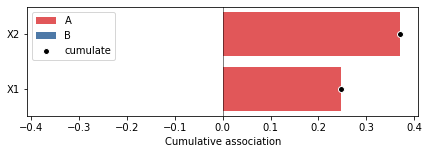

In [29]:
# plot cumulative visualizations
swt.plot_cumulative(attribute_sets['B1_X'])

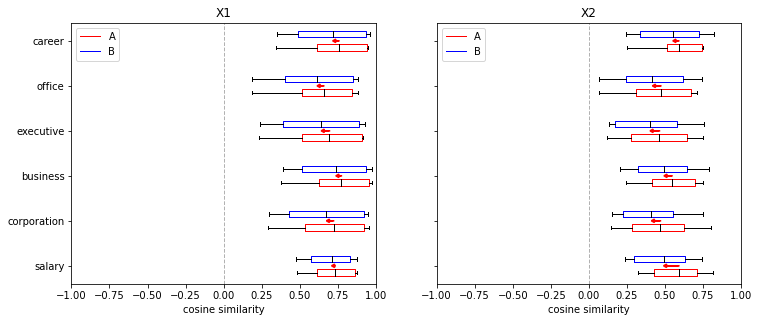

In [30]:
# plot cumulative visualizations
swt.plot_details(attribute_sets['B1_X'])